<a href="https://colab.research.google.com/github/DaraRahma536/Finalterm_ML/blob/main/CNN_3/UAS_ML_CNN_Dara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPLEMENTASI END-TO-END CNN UNTUK KLASIFIKASI GAMBAR**

## **1. Install Requirements**

In [1]:
pip install tensorflow numpy pandas matplotlib seaborn opencv-python scikit-learn

## **2. Memuat Dataset**

In [8]:
# ============================================
# FUNGSI UNTUK MEMUAT DATASET DARI GOOGLE DRIVE
# ============================================

import numpy as np
import os
import cv2
from PIL import Image
import requests
from io import BytesIO
import zipfile
import gdown
from google.colab import drive
import tensorflow as tf
from sklearn.model_selection import train_test_split


def load_dataset_from_gdrive_colab(drive_url="https://drive.google.com/drive/folders/15hDCm5WXIcBCOm0CVue-pbgOEhA0BoLt"):
    """
    Fungsi untuk memuat dataset dari Google Drive di Google Colab
    """
    print("Loading dataset from Google Drive...")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Dataset mungkin sudah ada di Google Drive user
    # Atau kita perlu download dari link yang diberikan

    # Method 1: Jika dataset sudah di-share secara publik
    try:
        # Install gdown jika belum ada
        !pip install -q gdown

        # Download dataset sebagai zip (jika tersedia sebagai zip)
        # Ganti FILE_ID dengan ID dari Google Drive
        # Untuk mendapatkan FILE_ID:
        # - Buka file di Google Drive
        # - URL akan seperti: https://drive.google.com/file/d/FILE_ID/view
        file_id = "15hDCm5WXIcBCOm0CVue-pbgOEhA0BoLt"  # ID dari link yang diberikan

        # Coba download sebagai zip
        !gdown --id $file_id --output dataset.zip

        # Extract zip
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/dataset')

        dataset_path = '/content/dataset'

    except:
        # Method 2: Jika dataset dalam folder dengan struktur tertentu
        print("Mencoba akses langsung ke folder...")

        # Untuk folder, kita perlu membuat direktori struktur manual
        dataset_path = '/content/drive/MyDrive/fish_dataset'  # Ganti dengan path yang sesuai

        # Jika tidak ada, coba cari
        if not os.path.exists(dataset_path):
            print("Mencari dataset di Google Drive...")
            # Cari folder dengan pattern tertentu
            import subprocess

            # Cari file yang mengandung 'fish' atau 'dataset'
            result = subprocess.run(['find', '/content/drive', '-type', 'd', '-name', '*fish*', '-o', '-name', '*dataset*'],
                                  capture_output=True, text=True)

            if result.stdout:
                possible_paths = result.stdout.strip().split('\n')
                dataset_path = possible_paths[0] if possible_paths else None
                print(f"Found possible dataset at: {dataset_path}")

    return dataset_path

# ============================================
# FUNGSI UTAMA UNTUK MEMUAT SELURUH DATASET
# ============================================

def load_fish_dataset(dataset_path=None, img_size=(224, 224)):
    """
    Fungsi utama untuk memuat dataset ikan dengan struktur train/test/val
    """
    print("="*60)
    print("MEMUAT DATASET IKAN")
    print("="*60)

    # Jika path tidak diberikan, coba load dari Google Drive
    if dataset_path is None:
        # Cek apakah di Colab
        try:
            import google.colab
            in_colab = True
        except:
            in_colab = False

        if in_colab:
            print("Detected Google Colab environment")
            dataset_path = load_dataset_from_gdrive_colab()
        else:
            print("Detected local environment")
            dataset_path = load_dataset_from_gdrive_local()

    # Pastikan dataset_path ada
    if not os.path.exists(dataset_path):
        # Coba cari dengan nama umum
        possible_paths = [
            dataset_path,
            "fish_dataset",
            "/content/drive/MyDrive/fish_dataset",
            "/content/fish_dataset",
            "./fish_dataset"
        ]

        for path in possible_paths:
            if os.path.exists(path):
                dataset_path = path
                break

    print(f"Dataset path: {dataset_path}")

    # Cek struktur folder
    print("\nChecking folder structure...")
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')
    val_path = os.path.join(dataset_path, 'val')

    # Jika tidak ada struktur train/test/val, mungkin dataset dalam format lain
    if not os.path.exists(train_path):
        print("Struktur train/test/val tidak ditemukan.")
        print("Mencoba format alternatif...")

        # Cek apakah langsung berisi folder kelas
        subdirs = [d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))]

        if len(subdirs) > 0:
            print(f"Ditemukan {len(subdirs)} subdirectories: {subdirs[:5]}...")

            # Split manual menjadi train/test/val
            return load_and_split_dataset(dataset_path, img_size)
        else:
            raise ValueError(f"Struktur dataset tidak valid di: {dataset_path}")

    # Load data dari masing-masing folder
    print("\nLoading training data...")
    X_train, y_train, class_names = load_images_from_folder(train_path, img_size)

    print("Loading test data...")
    X_test, y_test, _ = load_images_from_folder(test_path, img_size)

    print("Loading validation data...")
    X_val, y_val, _ = load_images_from_folder(val_path, img_size)

    # Print summary
    print("\n" + "="*60)
    print("DATASET SUMMARY")
    print("="*60)
    print(f"Classes: {class_names}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Image shape: {X_train[0].shape}")
    print("="*60)

    return (X_train, y_train), (X_test, y_test), (X_val, y_val), class_names

## **3. Import Library**

In [6]:
# IMPOR LIBRARY YANG DIPERLUKAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Library untuk deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

# Library untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Set random seed untuk reprodusibilitas
np.random.seed(42)
tf.random.set_seed(42)

print("Versi TensorFlow:", tf.__version__)
print("Versi Keras:", keras.__version__)

Versi TensorFlow: 2.19.0
Versi Keras: 3.10.0


## **4. Load Data**


EKSPLORASI DATASET
Shape training data: (50000, 32, 32, 3)
Shape training labels: (50000, 1)
Shape test data: (10000, 32, 32, 3)
Shape test labels: (10000, 1)

Jumlah kelas: 10

Distribusi kelas pada data training:
  Kelas 0: 5000 sampel
  Kelas 1: 5000 sampel
  Kelas 2: 5000 sampel
  Kelas 3: 5000 sampel
  Kelas 4: 5000 sampel
  Kelas 5: 5000 sampel
  Kelas 6: 5000 sampel
  Kelas 7: 5000 sampel
  Kelas 8: 5000 sampel
  Kelas 9: 5000 sampel


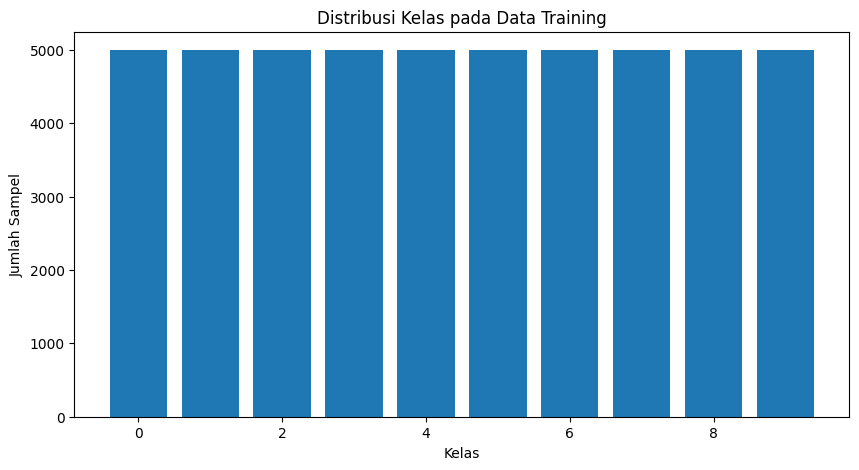

In [10]:
# ============================================
# LOAD DAN EKSPLORASI DATA
# ============================================


def load_and_explore_data():
    """
    Fungsi untuk memuat dan mengeksplorasi dataset
    """
    print("\n" + "="*50)
    print("EKSPLORASI DATASET")
    print("="*50)



    print(f"Shape training data: {x_train.shape}")
    print(f"Shape training labels: {y_train.shape}")
    print(f"Shape test data: {x_test.shape}")
    print(f"Shape test labels: {y_test.shape}")

    # Tampilkan informasi kelas
    num_classes = len(np.unique(y_train))
    print(f"\nJumlah kelas: {num_classes}")

    # Hitung jumlah sampel per kelas
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print("\nDistribusi kelas pada data training:")
    for cls, count in class_distribution.items():
        print(f"  Kelas {cls}: {count} sampel")

    # Visualisasi distribusi kelas
    plt.figure(figsize=(10, 5))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title('Distribusi Kelas pada Data Training')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.show()

    return (x_train, y_train), (x_test, y_test), num_classes

# Load data
(x_train, y_train), (x_test, y_test), num_classes = load_and_explore_data()

## **5. Visualisasi Sampel**

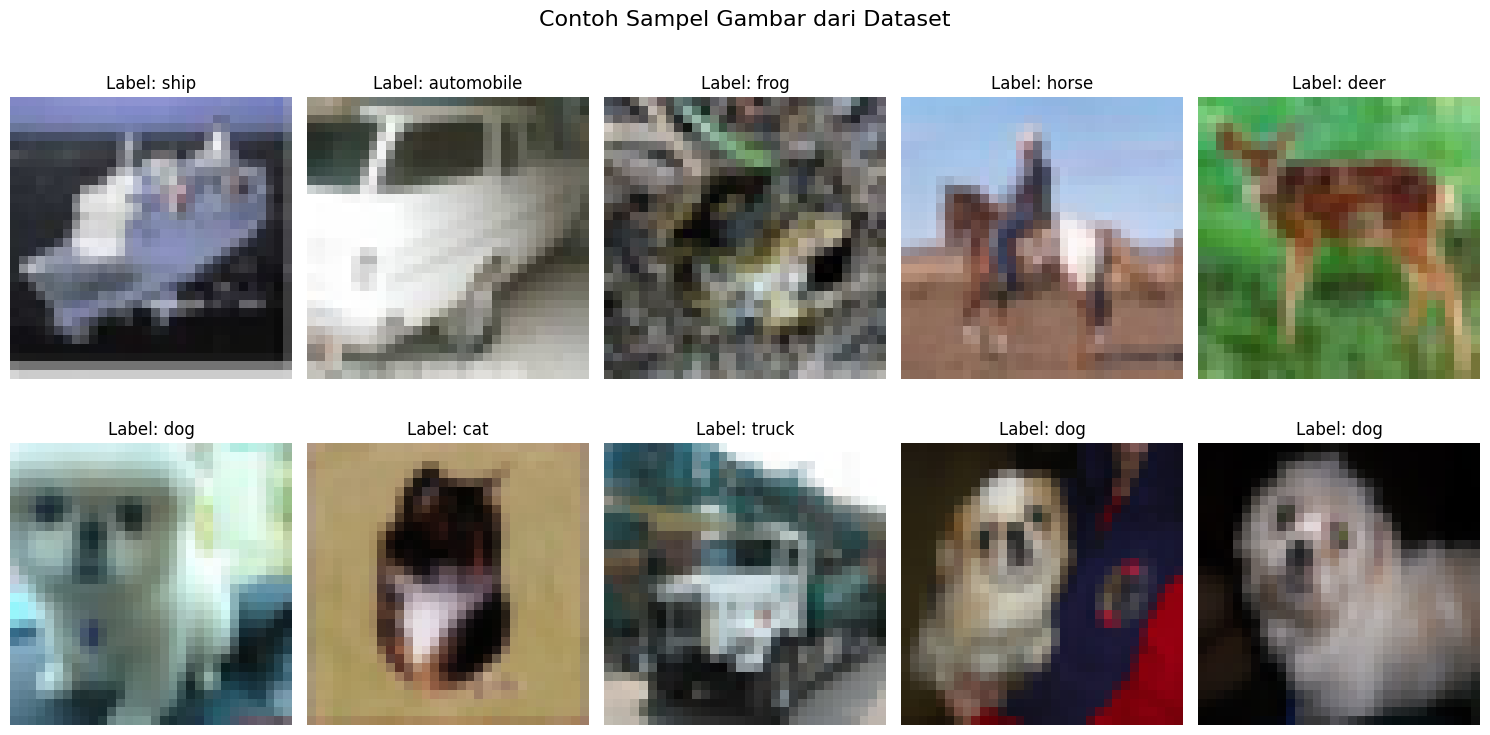

In [11]:
# ============================================
# VISUALISASI SAMPEL GAMBAR
# ============================================

def visualize_samples(images, labels, class_names=None, num_samples=10):
    """
    Fungsi untuk menampilkan sampel gambar dari dataset
    """
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]

    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        idx = random.randint(0, len(images)-1)
        plt.subplot(2, 5, i+1)
        plt.imshow(images[idx])
        plt.title(f'Label: {class_names[labels[idx][0]]}')
        plt.axis('off')
    plt.suptitle('Contoh Sampel Gambar dari Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

# Tampilkan contoh gambar
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
visualize_samples(x_train, y_train, class_names)

## **6. Preprocessing Data**

In [12]:
# ============================================
# PREPROCESSING DATA
# ============================================

def preprocess_data(x_train, x_test, y_train, y_test, num_classes):
    """
    Fungsi untuk preprocessing data
    """
    print("\n" + "="*50)
    print("PREPROCESSING DATA")
    print("="*50)

    # Normalisasi pixel values ke range [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encoding untuk label
    y_train_onehot = to_categorical(y_train, num_classes)
    y_test_onehot = to_categorical(y_test, num_classes)

    # Split data training menjadi training dan validation
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_train, y_train_onehot, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Data training shape: {x_train_split.shape}")
    print(f"Data validation shape: {x_val_split.shape}")
    print(f"Data test shape: {x_test.shape}")

    return x_train_split, x_val_split, x_test, y_train_split, y_val_split, y_test_onehot

# Preprocess data
x_train_split, x_val_split, x_test_preprocessed, y_train_split, y_val_split, y_test_onehot = preprocess_data(
    x_train, x_test, y_train, y_test, num_classes
)


PREPROCESSING DATA
Data training shape: (40000, 32, 32, 3)
Data validation shape: (10000, 32, 32, 3)
Data test shape: (10000, 32, 32, 3)


## **7. Augmentasi Data**

In [13]:
# ============================================
# AUGMENTASI DATA
# ============================================

def create_augmentation_generator():
    """
    Fungsi untuk membuat generator augmentasi data
    """
    print("\nMembuat generator augmentasi data...")

    datagen = ImageDataGenerator(
        rotation_range=20,           # Rotasi acak hingga 20 derajat
        width_shift_range=0.2,       # Pergeseran horizontal
        height_shift_range=0.2,      # Pergeseran vertikal
        horizontal_flip=True,        # Flip horizontal
        zoom_range=0.2,              # Zoom acak
        shear_range=0.2,             # Shear transformation
        fill_mode='nearest'          # Mengisi pixel yang hilang
    )

    return datagen

# Buat generator augmentasi
train_datagen = create_augmentation_generator()
val_datagen = ImageDataGenerator()  # Tidak augmentasi untuk validation


Membuat generator augmentasi data...


In [14]:
# ============================================
# HANDLING CLASS IMBALANCE
# ============================================

def handle_class_imbalance(y_train):
    """
    Fungsi untuk menghitung class weights untuk menangani imbalance
    """
    # Flatten labels
    y_train_flat = y_train.flatten()

    # Hitung class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_flat),
        y=y_train_flat
    )

    # Konversi ke dictionary
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    print("\n" + "="*50)
    print("CLASS WEIGHTS UNTUK HANDLE IMBALANCE")
    print("="*50)
    for cls, weight in class_weight_dict.items():
        print(f"Kelas {cls}: weight = {weight:.3f}")

    return class_weight_dict

# Hitung class weights
class_weight_dict = handle_class_imbalance(y_train)


CLASS WEIGHTS UNTUK HANDLE IMBALANCE
Kelas 0: weight = 1.000
Kelas 1: weight = 1.000
Kelas 2: weight = 1.000
Kelas 3: weight = 1.000
Kelas 4: weight = 1.000
Kelas 5: weight = 1.000
Kelas 6: weight = 1.000
Kelas 7: weight = 1.000
Kelas 8: weight = 1.000
Kelas 9: weight = 1.000


## **8. Membangun Model CNN**

In [15]:
# ============================================
# MEMBANGUN MODEL CNN DARI SCRATCH
# ============================================

def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Membangun model CNN dari scratch
    """
    print("\n" + "="*50)
    print("MEMBANGUN MODEL CNN DARI SCRATCH")
    print("="*50)

    model = Sequential([
        # Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    model.summary()
    return model

# Build CNN model
cnn_model = build_cnn_model(input_shape=x_train_split.shape[1:], num_classes=num_classes)


MEMBANGUN MODEL CNN DARI SCRATCH


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [16]:
# ============================================
# TRANSFER LEARNING DENGAN PRE-TRAINED MODEL
# ============================================

def build_transfer_learning_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Membangun model menggunakan transfer learning dengan VGG16
    """
    print("\n" + "="*50)
    print("TRANSFER LEARNING DENGAN VGG16")
    print("="*50)

    # Load pre-trained VGG16 tanpa top layer
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Build custom top layers
    inputs = keras.Input(shape=input_shape)

    # Preprocessing sesuai dengan VGG16
    x = applications.vgg16.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    model.summary()
    return model, base_model

# Build transfer learning model
tl_model, base_model = build_transfer_learning_model(
    input_shape=(32, 32, 3),  # Resize sesuai kebutuhan
    num_classes=num_classes
)


TRANSFER LEARNING DENGAN VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32, 32)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 32, 32)    │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 32, 32)    │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 32, 32, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 1, 1, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      1,290 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,881,738 (56.77 MB)

 Trainable params: 166,282 (649.54 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [17]:
# ============================================
# CALLBACKS UNTUK TRAINING
# ============================================

def create_callbacks(model_name='best_model.h5'):
    """
    Membuat callbacks untuk training
    """
    callbacks = [
        # Early stopping jika tidak ada improvement
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),

        # Reduce learning rate jika plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),

        # Save best model
        ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    return callbacks

## **9. Training Model**

In [ ]:
# ============================================
# TRAINING MODEL CNN
# ============================================

def train_model(model, x_train, y_train, x_val, y_val,
                class_weight=None, epochs=50, batch_size=64, model_name='cnn'):
    """
    Fungsi untuk training model
    """
    print(f"\n" + "="*50)
    print(f"TRAINING MODEL {model_name.upper()}")
    print("="*50)

    # Buat callbacks
    callbacks = create_callbacks(f"{model_name}_best.h5")

    # Training dengan augmentasi
    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

    # Training model
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=len(x_train) // batch_size,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    return history

# Training CNN model
print("\nTraining CNN model dari scratch...")
cnn_history = train_model(
    cnn_model,
    x_train_split, y_train_split,
    x_val_split, y_val_split,
    class_weight=class_weight_dict,
    epochs=50,
    model_name='cnn_from_scratch'
)

# Training Transfer Learning model
print("\nTraining Transfer Learning model...")
tl_history = train_model(
    tl_model,
    x_train_split, y_train_split,
    x_val_split, y_val_split,
    class_weight=class_weight_dict,
    epochs=30,
    model_name='transfer_learning'
)


Training CNN model dari scratch...

TRAINING MODEL CNN_FROM_SCRATCH
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - AUC: 0.6847 - accuracy: 0.2271 - loss: 2.4848
Epoch 1: val_accuracy improved from -inf to 0.46340, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 499s 786ms/step - AUC: 0.6848 - accuracy: 0.2272 - loss: 2.4843 - val_AUC: 0.8770 - val_accuracy: 0.4634 - val_loss: 1.4682 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - AUC: 0.8401 - accuracy: 0.3973 - loss: 1.6488
Epoch 2: val_accuracy did not improve from 0.46340
625/625 ━━━━━━━━━━━━━━━━━━━━ 403s 628ms/step - AUC: 0.8401 - accuracy: 0.3973 - loss: 1.6487 - val_AUC: 0.8505 - val_accuracy: 0.4277 - val_loss: 1.7192 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - AUC: 0.8806 - accuracy: 0.4785 - loss: 1.4417
Epoch 3: val_accuracy improved from 0.46340 to 0.49840, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 391s 625ms/step - AUC: 0.8806 - accuracy: 0.4785 - loss: 1.4416 - val_AUC: 0.8849 - val_accuracy: 0.4984 - val_loss: 1.4703 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - AUC: 0.9015 - accuracy: 0.5303 - loss: 1.3142
Epoch 4: val_accuracy improved from 0.49840 to 0.52100, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 394s 630ms/step - AUC: 0.9015 - accuracy: 0.5303 - loss: 1.3142 - val_AUC: 0.8980 - val_accuracy: 0.5210 - val_loss: 1.4030 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - AUC: 0.9154 - accuracy: 0.5707 - loss: 1.2165
Epoch 5: val_accuracy improved from 0.52100 to 0.58440, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 441s 630ms/step - AUC: 0.9154 - accuracy: 0.5707 - loss: 1.2165 - val_AUC: 0.9163 - val_accuracy: 0.5844 - val_loss: 1.2182 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - AUC: 0.9252 - accuracy: 0.6039 - loss: 1.1431
Epoch 6: val_accuracy improved from 0.58440 to 0.64840, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 627ms/step - AUC: 0.9252 - accuracy: 0.6039 - loss: 1.1431 - val_AUC: 0.9441 - val_accuracy: 0.6484 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - AUC: 0.9348 - accuracy: 0.6280 - loss: 1.0685
Epoch 7: val_accuracy did not improve from 0.64840
625/625 ━━━━━━━━━━━━━━━━━━━━ 393s 630ms/step - AUC: 0.9348 - accuracy: 0.6280 - loss: 1.0685 - val_AUC: 0.9205 - val_accuracy: 0.6033 - val_loss: 1.2069 - learning_rate: 0.0010
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - AUC: 0.9384 - accuracy: 0.6422 - loss: 1.0342
Epoch 8: val_accuracy improved from 0.64840 to 0.72740, saving model to cnn_from_scratch_best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 441s 628ms/step - AUC: 0.9384 - accuracy: 0.6423 - loss: 1.0342 - val_AUC: 0.9645 - val_accuracy: 0.7274 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - AUC: 0.9452 - accuracy: 0.6627 - loss: 0.9766
Epoch 9: val_accuracy did not improve from 0.72740
625/625 ━━━━━━━━━━━━━━━━━━━━ 442s 627ms/step - AUC: 0.9452 - accuracy: 0.6627 - loss: 0.9766 - val_AUC: 0.9542 - val_accuracy: 0.6975 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - AUC: 0.9486 - accuracy: 0.6741 - loss: 0.9429
Epoch 10: val_accuracy did not improve from 0.72740
625/625 ━━━━━━━━━━━━━━━━━━━━ 394s 630ms/step - AUC: 0.9486 - accuracy: 0.6741 - loss: 0.9429 - val_AUC: 0.9493 - val_accuracy: 0.6926 - val_loss: 0.9624 - learning_rate: 0.0010
Epoch 11/50
  7/625 ━━━━━━━━━━━━━━━━━━━━ 7:48 758ms/step - AUC: 0.9633 - accuracy: 0.7416 - loss: 0.7992

## **10. Fine-Tuning Model**

In [ ]:
# ============================================
# 11. FINE-TUNING TRANSFER LEARNING MODEL
# ============================================

def fine_tune_model(model, base_model, x_train, y_train, x_val, y_val):
    """
    Fine-tuning untuk transfer learning model
    """
    print("\n" + "="*50)
    print("FINE-TUNING TRANSFER LEARNING MODEL")
    print("="*50)

    # Unfreeze beberapa layer terakhir
    base_model.trainable = True

    # Freeze layer awal, unfreeze layer akhir
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True

    # Recompile dengan learning rate lebih rendah
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    # Training untuk fine-tuning
    callbacks = create_callbacks("fine_tuned_best.h5")

    history_finetune = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return history_finetune

# Fine-tuning
finetune_history = fine_tune_model(
    tl_model, base_model,
    x_train_split, y_train_split,
    x_val_split, y_val_split
)

## **11. Evaluasi Model**

In [ ]:
# ============================================
# EVALUASI MODEL
# ============================================

def evaluate_model(model, x_test, y_test, model_name="Model"):
    """
    Fungsi untuk evaluasi model
    """
    print(f"\n" + "="*50)
    print(f"EVALUASI {model_name.upper()}")
    print("="*50)

    # Predict
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Akurasi: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names[:num_classes]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[:num_classes],
                yticklabels=class_names[:num_classes])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred

# Evaluate semua model
print("\nEvaluasi CNN dari scratch...")
cnn_accuracy, cnn_predictions = evaluate_model(cnn_model, x_test_preprocessed, y_test_onehot, "CNN dari Scratch")

print("\nEvaluasi Transfer Learning model...")
tl_accuracy, tl_predictions = evaluate_model(tl_model, x_test_preprocessed, y_test_onehot, "Transfer Learning VGG16")

## **12. Visualisasi Hasil**

In [ ]:
# ============================================
# VISUALISASI HASIL TRAINING
# ============================================

def plot_training_history(history, model_name="Model"):
    """
    Fungsi untuk plotting history training
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot history untuk semua model
print("\nVisualisasi training history...")
plot_training_history(cnn_history, "CNN dari Scratch")
plot_training_history(tl_history, "Transfer Learning")
plot_training_history(finetune_history, "Fine-tuned Model")

In [ ]:
# ============================================
# 14. VISUALISASI PREDIKSI
# ============================================

def visualize_predictions(images, true_labels, pred_labels, class_names, num_samples=10):
    """
    Fungsi untuk visualisasi prediksi model
    """
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(images)-1)

        plt.subplot(2, 5, i+1)
        plt.imshow(images[idx])

        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]

        color = 'green' if true_class == pred_class else 'red'

        plt.title(f'True: {true_class}\nPred: {pred_class}', color=color)
        plt.axis('off')

    plt.suptitle('Contoh Prediksi Model', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualisasi prediksi
print("\nVisualisasi contoh prediksi...")
y_true_labels = np.argmax(y_test_onehot, axis=1)

# Gunakan CNN predictions
visualize_predictions(
    x_test[:100],  # Gunakan data asli (belum dinormalisasi untuk visualisasi)
    y_true_labels[:100],
    cnn_predictions[:100],
    class_names
)

In [ ]:
# ============================================
# 15. VISUALISASI CNN LAYERS (FEATURE MAPS)
# ============================================

def visualize_feature_maps(model, image, layer_names=None):
    """
    Fungsi untuk visualisasi feature maps dari layer CNN
    """
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name][:3]

    # Buat model untuk mendapatkan output dari layer tertentu
    outputs = [model.get_layer(name).output for name in layer_names]
    vis_model = Model(inputs=model.input, outputs=outputs)

    # Predict untuk satu gambar
    img_array = np.expand_dims(image, axis=0)
    feature_maps = vis_model.predict(img_array)

    # Visualisasi feature maps
    for layer_name, fmap in zip(layer_names, feature_maps):
        print(f"\nLayer: {layer_name}, Feature map shape: {fmap.shape}")

        # Ambil beberapa feature maps pertama
        num_features = min(8, fmap.shape[-1])

        plt.figure(figsize=(15, 2))
        plt.suptitle(f'Feature Maps - {layer_name}', fontsize=16)

        for i in range(num_features):
            plt.subplot(1, num_features, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
            plt.title(f'FM {i+1}')

        plt.tight_layout()
        plt.show()

# Pilih satu gambar contoh
sample_image = x_test[0]
print("\nVisualisasi Feature Maps...")
visualize_feature_maps(cnn_model, sample_image)

## **13. Simpan Hasil**

In [ ]:
# ============================================
# 16. SIMPAN MODEL DAN HASIL
# ============================================

def save_models_and_results(cnn_model, tl_model, cnn_accuracy, tl_accuracy):
    """
    Fungsi untuk menyimpan model dan hasil
    """
    print("\n" + "="*50)
    print("MENYIMPAN MODEL DAN HASIL")
    print("="*50)

    # Simpan model
    cnn_model.save('cnn_fish_classifier.h5')
    tl_model.save('transfer_learning_fish_classifier.h5')

    print("Model CNN disimpan sebagai: cnn_fish_classifier.h5")
    print("Model Transfer Learning disimpan sebagai: transfer_learning_fish_classifier.h5")

    # Simpan hasil evaluasi
    results = {
        'CNN_Accuracy': cnn_accuracy,
        'Transfer_Learning_Accuracy': tl_accuracy,
        'Num_Classes': num_classes,
        'Input_Shape': x_train_split.shape[1:]
    }

    import json
    with open('training_results.json', 'w') as f:
        json.dump(results, f, indent=4)

    print("Hasil evaluasi disimpan sebagai: training_results.json")

    # Tampilkan perbandingan akurasi
    plt.figure(figsize=(8, 5))
    models = ['CNN dari Scratch', 'Transfer Learning']
    accuracies = [cnn_accuracy, tl_accuracy]

    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
    plt.title('Perbandingan Akurasi Model')
    plt.ylabel('Akurasi')
    plt.ylim([0, 1])

    # Tambahkan nilai pada bar
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Simpan model dan hasil
save_models_and_results(cnn_model, tl_model, cnn_accuracy, tl_accuracy)

In [ ]:
# ============================================
# 17. FUNGSI UNTUK PREDIKSI BARU
# ============================================

def predict_new_image(model, image_path, class_names, img_size=(32, 32)):
    """
    Fungsi untuk melakukan prediksi pada gambar baru
    """
    # Load dan preprocess gambar
    img = Image.open(image_path)
    img = img.resize(img_size)
    img_array = np.array(img)

    # Jika gambar grayscale, konversi ke RGB
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array]*3, axis=-1)

    # Normalisasi
    img_array = img_array.astype('float32') / 255.0

    # Tambahkan batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Tampilkan hasil
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.title(f'Gambar Input')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.bar(range(len(predictions[0])), predictions[0])
    plt.title(f'Prediksi: {class_names[predicted_class]} ({confidence:.2%})')
    plt.xlabel('Kelas')
    plt.ylabel('Probabilitas')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

    return predicted_class, confidence, predictions[0]

print("\n" + "="*50)
print("IMPLEMENTASI SELESAI")
print("="*50)
print("\nPipeline End-to-End untuk klasifikasi gambar telah selesai!")
print("Model telah dilatih dan dievaluasi dengan metrik yang sesuai.")
print("\nFitur yang telah diimplementasikan:")
print("1. Eksplorasi dan visualisasi data")
print("2. Preprocessing dan augmentasi data")
print("3. Handling class imbalance")
print("4. CNN dari scratch")
print("5. Transfer learning dengan VGG16")
print("6. Fine-tuning model")
print("7. Evaluasi dengan berbagai metrik")
print("8. Visualisasi feature maps")
print("9. Prediksi pada gambar baru")